In [2]:
import pandas as pd
import numpy as np
import string
from random import sample
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from IPython.display import clear_output

import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))

cuda device is available


In [4]:
df = pd.read_excel('hackaton_result_dataset.xlsx')

In [5]:
df_for_dict = df['human_markup']
df_for_generation = df['model_annotation']

>***Предобработка текстов (и того, из которого собираем словарь, и того, который будем догенерировать)***

In [6]:
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize 
import pymorphy2
import nltk
from nltk.corpus import stopwords  

In [7]:
morph = pymorphy2.MorphAnalyzer() # перевод слова в исходную форму

In [8]:
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olg-k\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# т.к. предложенный текст сам по себе несет слабую смысловую нагрузку, то стандартный nltk список русских стоп-слов убирает из фразы 2/3, сделала усеченный
stopword_ru_short = []
for _ in stopword_ru:
    if len(_) < 3:
        stopword_ru_short.append(_)

In [10]:
# визуально все строки уже приведены к нижнему регистру и из них уадалены небуквенные символы (знаки препинания и т.д.),
# поэтому этап очистки текстов опустим и перейдем к лемматизации

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):
    # переводим зашедший текст в строку
    if not isinstance(text, str):
        text = str(text)

    # делим на слова пришедшую строку 
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    # собственно лемматизация слов 
    words_lem = []
    for word in words:
        if len(word) > 1:  # для слов длиной в 1 символ не имеет смысла
            if word in cache: # чтобы не повторяться
                words_lem.append(cache[word])
            else: 
                temp_cach = cache[word] = morph.parse(word)[0].normal_form
                words_lem.append(temp_cach)

    # выкидываем стоп-слова
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru_short]

    return words_lem_without_stopwords

In [11]:
%%time
from tqdm import tqdm
tqdm.pandas()

# применяем лемматизацию к обоим частям нашего текста
df_for_dict = df_for_dict.progress_apply(lambda x: lemmatization(x))
df_for_generation = df_for_generation.progress_apply(lambda x: lemmatization(x))

100%|██████████| 6508/6508 [00:00<00:00, 9577.41it/s]

CPU times: total: 141 ms
Wall time: 1.79 s


>***Обучение модели на текстах, размеченных человеком*** 

In [12]:
# функция для добавления меток начала и конца предложения
def add_start_finish(df):
    for i in df:
        i.insert(0, '<sos>')
        i.append('<eos>')
    return df

In [13]:
df_for_dict_s_f = df_for_dict.to_list()
df_for_dict_s_f = add_start_finish(df_for_dict_s_f)

df_for_generation_s_f = df_for_generation.to_list()
df_for_generation_s_f = add_start_finish(df_for_generation_s_f)

In [14]:
# Создадим словарь из обучаещего набора
common_dictionary = Dictionary(df_for_dict.to_list())
common_corpus = [common_dictionary.doc2bow(text) for text in df_for_dict.to_list()]

In [15]:
common_dictionary.add_documents([['<sos>'], ['<eos>'], ['<pad>']])

In [16]:
len(common_dictionary) #размер входного слоя

5546

In [17]:
# Выравниваем длины векторов для батча
def to_matrix(df_for_dict_s_f, max_len=None, pad=common_dictionary.doc2idx(['<pad>'])[0], dtype='int32', batch_first=True): 
    max_len = max_len or max(map(len, df_for_dict_s_f))
    max_len += 1
    names_ix = np.zeros([len(df_for_dict_s_f), max_len], dtype) + pad
    names_ix[:, 0] = common_dictionary.doc2idx(['<sos>'])[0]

    for i in range(len(df_for_dict_s_f)):
        line_ix = common_dictionary.doc2idx(df_for_dict_s_f[i])
        names_ix[i, 1:len(line_ix)] = line_ix[1:]
        names_ix[i, len(line_ix)] = common_dictionary.doc2idx(['<eos>'])[0]

        
    if not batch_first: 
        names_ix = np.transpose(names_ix)

    return names_ix

In [18]:
# для теста пока возьмем GRU - RNN 
class GruRnn(nn.Module):
    def __init__(self, num_tokens = len(common_dictionary), emb_size = 18, hidden_size = 64, n_layers=1):
        super(GruRnn, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.emb_size = emb_size

        self.encoder = nn.Embedding(num_tokens, emb_size)
        self.gru = nn.GRU(emb_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, num_tokens)

    def forward(self, input, hidden):
        input_enb = self.encoder(input)
        output, hidden = self.gru(input_enb[None, :, :], hidden)
        output = self.decoder(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [19]:
model_grurnn = GruRnn()

In [20]:
# цикл запуска модели
def rnn_loop(model_grurnn, batch_ix):

    batch_size, max_length = batch_ix.size()
    hid_state = model_grurnn.init_hidden(batch_size)
    logits = []

    for x_t in batch_ix.transpose(0,1):
        logits_next, hid_state = model_grurnn(x_t, hid_state)  
        logits.append(logits_next)
        
    return torch.stack(logits, dim=1)

In [21]:
max_length_ = max(map(len, df_for_dict_s_f))
max_length_

46

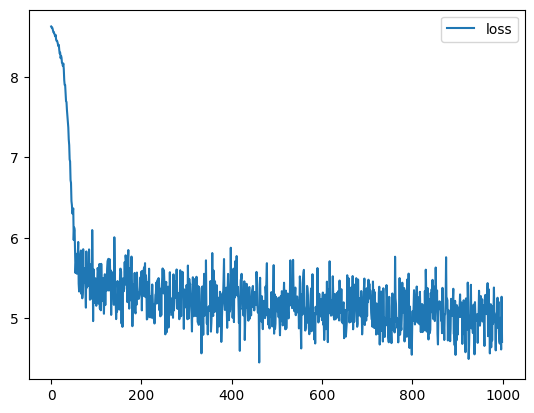

In [22]:
# обучение модели

from IPython.display import clear_output
from random import sample

model_grurnn = GruRnn()
opt = torch.optim.Adam(model_grurnn.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=common_dictionary.doc2idx(['<pad>'])[0])

history = []

for i in range(1000):
    batch_ix = to_matrix(sample(df_for_dict_s_f, 32), max_len=max_length_)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logits_seq = rnn_loop(model_grurnn, batch_ix).permute(0,2,1,3)
    
    # compute loss
    predictions_logits = logits_seq[:, :, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
    loss = loss_func(
    predictions_logits.reshape((-1, len(common_dictionary))),
    actual_next_tokens.reshape(-1)
    )

    loss.backward()
    opt.step()
    
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [23]:
# Сохранение 
torch.save(model_grurnn, 'model_1.pth')

> ***Генерация текста (генерация окончания фразы по первой половине)***

In [42]:
# Генерация текста

def generate_sample(model_grurnn, seed_phrase, max_length, temperature=1.0):
    
    x_sequence = common_dictionary.doc2idx(seed_phrase)
    x_sequence = [0 if x == -1 else x for x in x_sequence]       
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = model_grurnn.init_hidden(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        _, hid_state = model_grurnn(x_sequence[:, i], hid_state)
    
    # generating
    for _ in range(max_length - len(seed_phrase)):
        logits_next, hid_state = model_grurnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0][0]
        p_next = p_next[2:(len(common_dictionary)-2)]
        p_next = p_next + (1 - sum(p_next)) / len(p_next)
        next_ix = np.random.choice(np.arange(2, len(common_dictionary)-2), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        # if next_ix == common_dictionary.doc2idx(['<eos>'])[0]:
        #   break
    return ' '.join([common_dictionary.id2token[ix] for ix in x_sequence.data.numpy()[0]])

In [25]:
df['Generated text'] = np.nan

In [26]:
df['Generated_enb'] = np.nan
df['Start_enb'] = np.nan
df['cosin_similarity'] = np.nan

In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
for i in range(0, len(df_for_generation)):
    if len(df_for_generation[i]) > 2:
        df['Generated text'][i] = generate_sample(
            model_grurnn,
            seed_phrase = df_for_generation[i][0:(len(df_for_generation[i])//2 + 1)],
            max_length = len(df_for_generation[i]) - 1,
            temperature = 0.5  
        )
    else:
        df['Generated text'][i] = df_for_generation[i]

C:\Users\olg-k\AppData\Local\Temp\ipykernel_19764\2288997839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Generated text'][i] = generate_sample(


In [44]:
df['Start_enb'] = df.apply(lambda row: common_dictionary.doc2idx(df_for_generation[row.name]), axis=1) # эмбединги машинного изначального текста


In [45]:
# служебная функция
def str_to_emb(row):
    m = df['Generated text'][row]
    if type(m) == list:
       return common_dictionary.doc2idx(m)
    else:
        k = m.split()
        return common_dictionary.doc2idx(k)

In [46]:
df['Generated_enb'] = df.apply(lambda row: str_to_emb(row.name), axis=1) # эмбединги сгенерированного текста

In [47]:
# косинусное расстояние
import itertools
def cosin_similarity(row):
    a = df['Generated_enb'][row]
    b = df['Start_enb'][row]
    if len(a) == len(b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    elif len(a) > len(b):
        m = [0]*len(a)
        n = [x + y for x, y in itertools.zip_longest(m, b, fillvalue=0)]
        return np.dot(a, n) / (np.linalg.norm(a) * np.linalg.norm(n))
    elif len(a) < len(b):
        m = [0]*len(b)
        n = [x + y for x, y in itertools.zip_longest(m, a, fillvalue=0)]
        return np.dot(n, b) / (np.linalg.norm(n) * np.linalg.norm(b))

In [48]:
df['cosin_similarity'] = df.apply(lambda row: cosin_similarity(row.name), axis=1) 

In [49]:
df[40:70]

,model_annotation,human_markup,audio_path,label,Generated text,Generated_enb,Start_enb,cosin_similarity
40,я спросил у меня нет,ты спросил у меня нет,s3://ap-training-set/xacaton_openstt/part_1/05...,0,<sos> спросить нет,"[1, 155, 22]","[1, 155, 22, 0]",1.000000
41,номер нет этот дом,номер нет это дом,s3://ap-training-set/xacaton_openstt/part_1/05...,0,<sos> номер нет этот повстречать,"[1, 39, 22, 144, 1758]","[1, 39, 22, 144, 16, 0]",0.190110
42,про военной сбор пел,про военные сборы пел,s3://ap-training-set/xacaton_openstt/part_1/05...,1,<sos> про военный сбор быстро,"[1, 158, 156, 159, 3]","[1, 158, 156, 159, 157, 0]",0.872371
43,что такой,ты кто такой,s3://ap-training-set/xacaton_openstt/part_1/05...,1,<sos> что такой,"[1, 13, 160]","[1, 13, 160, 0]",1.000000
44,ты мне чего звонишь,ты мне чё звонишь,s3://ap-training-set/xacaton_openstt/part_1/05...,0,<sos> что звонить,"[1, 13, 17]","[1, 13, 17, 0]",1.000000
45,туда подлей тебя и нету на свете даже,ну да подлей тебя и нету на свете даже,s3://ap-training-set/xacaton_openstt/part_1/05...,0,<sos> туда подлить нету ковыряться удобный,"[1, 450, 163, 162, 546, 3187]","[1, 450, 163, 162, 164, 161, 0]",0.472279
46,любой допреза ваши деньги,любой каприз за ваши деньги,s3://ap-training-set/xacaton_openstt/part_1/05...,0,<sos> любой <eos> ваш саша,"[1, 55, 0, 165, 2531]","[1, 55, -1, 165, 166, 0]",0.738391
47,ну вы дежурные что я должна сделать,ну вы дежурный и что я должна сделать,s3://ap-training-set/xacaton_openstt/part_1/05...,0,<sos> дежурный что должный удовлетворяться,"[1, 33, 13, 168, 4219]","[1, 33, 13, 168, 169, 0]",0.729870
48,да это страшно ты же мне что то там э ну тоже ...,тааак это страшно ты же мне шо то там эээ ну т...,s3://ap-training-set/xacaton_openstt/part_1/05...,0,<sos> это страшно что там тоже блядь превосход...,"[1, 47, 171, 13, 86, 173, 2, 975, 1340]","[1, 47, 171, 13, 86, 173, 38, 158, 170, 0]",0.762336
49,какому времени,какому времени,s3://ap-training-set/xacaton_openstt/part_1/05...,0,<sos> какой время,"[1, 170, 174]","[1, 170, 174, 0]",1.000000


In [51]:
df['cosin_similarity'].corr(df['label'])

-0.0034355016378505424

>***Вывод***  
Корреляция отсутствует вероятно из-за низкого качества генерации (причина - малый набор данных для обучения)